In [9]:
import sys
sys.executable

'/home/yoeriapts/.pyenv/versions/torch_ecg/bin/python3.10'

In [10]:
from easydict import EasyDict as ED

In [11]:
import pandas as pd
import sys
import numpy as np
# ^^^ pyforest auto-imports - don't write above this line
try:
    import bib_lookup
except ModuleNotFoundError:
    sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/bib_lookup/")
try:
    from torch_ecg.utils.misc import MovingAverage, list_sum
except ModuleNotFoundError:
    #sys.path.insert(0, "/home/wenhao/Jupyter/wenhao/workspace/torch_ecg/")
    sys.path.insert(0, "/home/yoeriapts/workspace/torch_ecg/")
    from torch_ecg.utils.misc import MovingAverage, list_sum

In [12]:
from cfg import TrainCfg, TrainCfg_ns, ModelCfg, ModelCfg_ns
from model import ECG_CRNN_CINC2021
from dataset import CINC2021
from trainer import CINC2021Trainer

from tqdm.auto import tqdm
from copy import deepcopy

from torch.nn.parallel import DistributedDataParallel as DDP, DataParallel as DP

In [13]:
ECG_CRNN_CINC2021.__DEBUG__ = False
CINC2021Trainer.__DEBUG__ = False
CINC2021.__DEBUG__ = False

In [14]:
# TrainCfg_ns.db_dir = "/home/wenhao/Jupyter/wenhao/data/CinC2021/"
# TrainCfg.db_dir = "/home/wenhao/Jupyter/wenhao/data/CinC2021/"
TrainCfg_ns.db_dir = "/home/yoeriapts/workspace/Datasets/physionet.org/files/challenge-2021/1.0.3/training/"
TrainCfg.db_dir = "/home/yoeriapts/workspace/Datasets/physionet.org/files/challenge-2021/1.0.3/training/"

In [ ]:
ds_train = CINC2021(TrainCfg_ns, training=True, lazy=False)
ds_val = CINC2021(TrainCfg_ns, training=False, lazy=False)

TorchECG-CINC2021 - INFO - converting dtypes of columns `diagnosis` and `diagnosis_scored`...

start performing train test split...

train test split finished in 0.02 minutes


Loading data:   0%|                                                                                           …

## 12 lead, resnet_nature_comm_bottle_neck_se, 1-linear, AsymmetricLoss, lr=1e-4 to 2e-3, one cycle

In [15]:
train_config = deepcopy(TrainCfg_ns)
train_config.cnn_name = "resnet_nature_comm_bottle_neck_se"
train_config.rnn_name = "none"
train_config.attn_name = "none"

In [16]:
print(sys.executable)

/home/yoeriapts/.pyenv/versions/torch_ecg/bin/python3.10


In [17]:
import torch
print(torch.cuda.is_available())

True


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
train_config.n_leads = len(train_config.leads)

tranches = train_config.tranches_for_training
if tranches:
    classes = train_config.tranche_classes[tranches]
else:
    classes = train_config.classes

if train_config.n_leads == 12:
    model_config = deepcopy(ModelCfg_ns.twelve_leads)
elif train_config.n_leads == 6:
    model_config = deepcopy(ModelCfg_ns.six_leads)
elif train_config.n_leads == 4:
    model_config = deepcopy(ModelCfg_ns.four_leads)
elif train_config.n_leads == 3:
    model_config = deepcopy(ModelCfg_ns.three_leads)
elif train_config.n_leads == 2:
    model_config = deepcopy(ModelCfg_ns.two_leads)
model_config.cnn.name = train_config.cnn_name
model_config.rnn.name = train_config.rnn_name
model_config.attn.name = train_config.attn_name
model_config.clf = ED()
model_config.clf.out_channels = [
  # not including the last linear layer, whose out channels equals n_classes
]
model_config.clf.bias = True
model_config.clf.dropouts = 0.0
model_config.clf.activation = "mish"  # for a single layer `SeqLin`, activation is ignored

In [20]:
model = ECG_CRNN_CINC2021(
    classes=train_config.classes,
    n_leads=train_config.n_leads,
    config=model_config,
)

In [0]:
model.module_size_

In [0]:
model

In [28]:
torch.onnx.export

<function torch.onnx.utils.export(model: 'Union[torch.nn.Module, torch.jit.ScriptModule, torch.jit.ScriptFunction]', args: 'Union[Tuple[Any, ...], torch.Tensor]', f: 'Union[str, io.BytesIO]', export_params: 'bool' = True, verbose: 'bool' = False, training: '_C_onnx.TrainingMode' = <TrainingMode.EVAL: 0>, input_names: 'Optional[Sequence[str]]' = None, output_names: 'Optional[Sequence[str]]' = None, operator_export_type: '_C_onnx.OperatorExportTypes' = <OperatorExportTypes.ONNX: 0>, opset_version: 'Optional[int]' = None, do_constant_folding: 'bool' = True, dynamic_axes: 'Optional[Union[Mapping[str, Mapping[int, str]], Mapping[str, Sequence[int]]]]' = None, keep_initializers_as_inputs: 'Optional[bool]' = None, custom_opsets: 'Optional[Mapping[str, int]]' = None, export_modules_as_functions: 'Union[bool, Collection[Type[torch.nn.Module]]]' = False) -> 'None'>

In [ ]:
if torch.cuda.device_count() > 1:
    model = DP(model)
    # model = DDP(model)
model.to(device=device)

In [ ]:
trainer = CINC2021Trainer(
    model=model,
    model_config=model_config,
    train_config=train_config,
    device=device,
    lazy=True,
)

In [ ]:
trainer._setup_dataloaders(ds_train, ds_val)

In [ ]:
trainer.train()

In [17]:
trainer

NameError: name 'trainer' is not defined

## collect results

In [3]:
import seaborn as sns
from matplotlib.pyplot import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [4]:

sns.set()

plt.rcParams['xtick.labelsize']=28
plt.rcParams['ytick.labelsize']=28
plt.rcParams['axes.labelsize']=40
plt.rcParams['legend.fontsize']=24

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

markers = ["p", "v", "s", "d", "x", "*", "+", "$\heartsuit$"]
marker_size = 12

In [7]:
from torch_ecg.utils.misc import MovingAverage, list_sum

In [8]:
# ma = MovingAverage()
ma_ea = MovingAverage()

ma = lambda x: x

In [9]:
# df_ms = pd.read_csv("./results/TorchECG_11-19_22-31_ECG_CRNN_CINC2021_adamw_amsgrad_LR_0.0001_BS_64_multi_scopic.csv")
# df_ms_lw = pd.read_csv("./results/TorchECG_11-24_00-21_ECG_CRNN_CINC2021_adamw_amsgrad_LR_0.0001_BS_64_multi_scopic_leadwise.csv")

df_ms = pd.read_csv("./log/TorchECG_05-15_13-08_ECG_CRNN_CINC2021_adamw_amsgrad_LR_0.0001_BS_64_resnet_nature_comm_bottle_neck_se.csv")
#df_ms_lw = pd.read_csv("./results/TorchECG_11-24_00-21_ECG_CRNN_CINC2021_adamw_amsgrad_LR_0.0001_BS_64_multi_scopic_leadwise.csv")


In [13]:
df_ms_train = df_ms[df_ms.part=="train"].dropna(subset=["challenge_metric"])
#df_ms_lw_train = df_ms_lw[df_ms_lw.part=="train"].dropna(subset=["challenge_metric"])
df_ms_val = df_ms[df_ms.part=="val"]
#df_ms_lw_val = df_ms_lw[df_ms_lw.part=="val"]

In [14]:
df_lr = df_ms[["epoch","loss","lr","part","step",]]
df_lr.step = (df_lr.step/20)/53

/tmp/ipykernel_3889241/2952244720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lr.step = (df_lr.step/20)/53


/tmp/ipykernel_3889241/67257338.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.step = (df_tmp.step/20)/53
/tmp/ipykernel_3889241/67257338.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.step = (df_tmp.step/20)/53


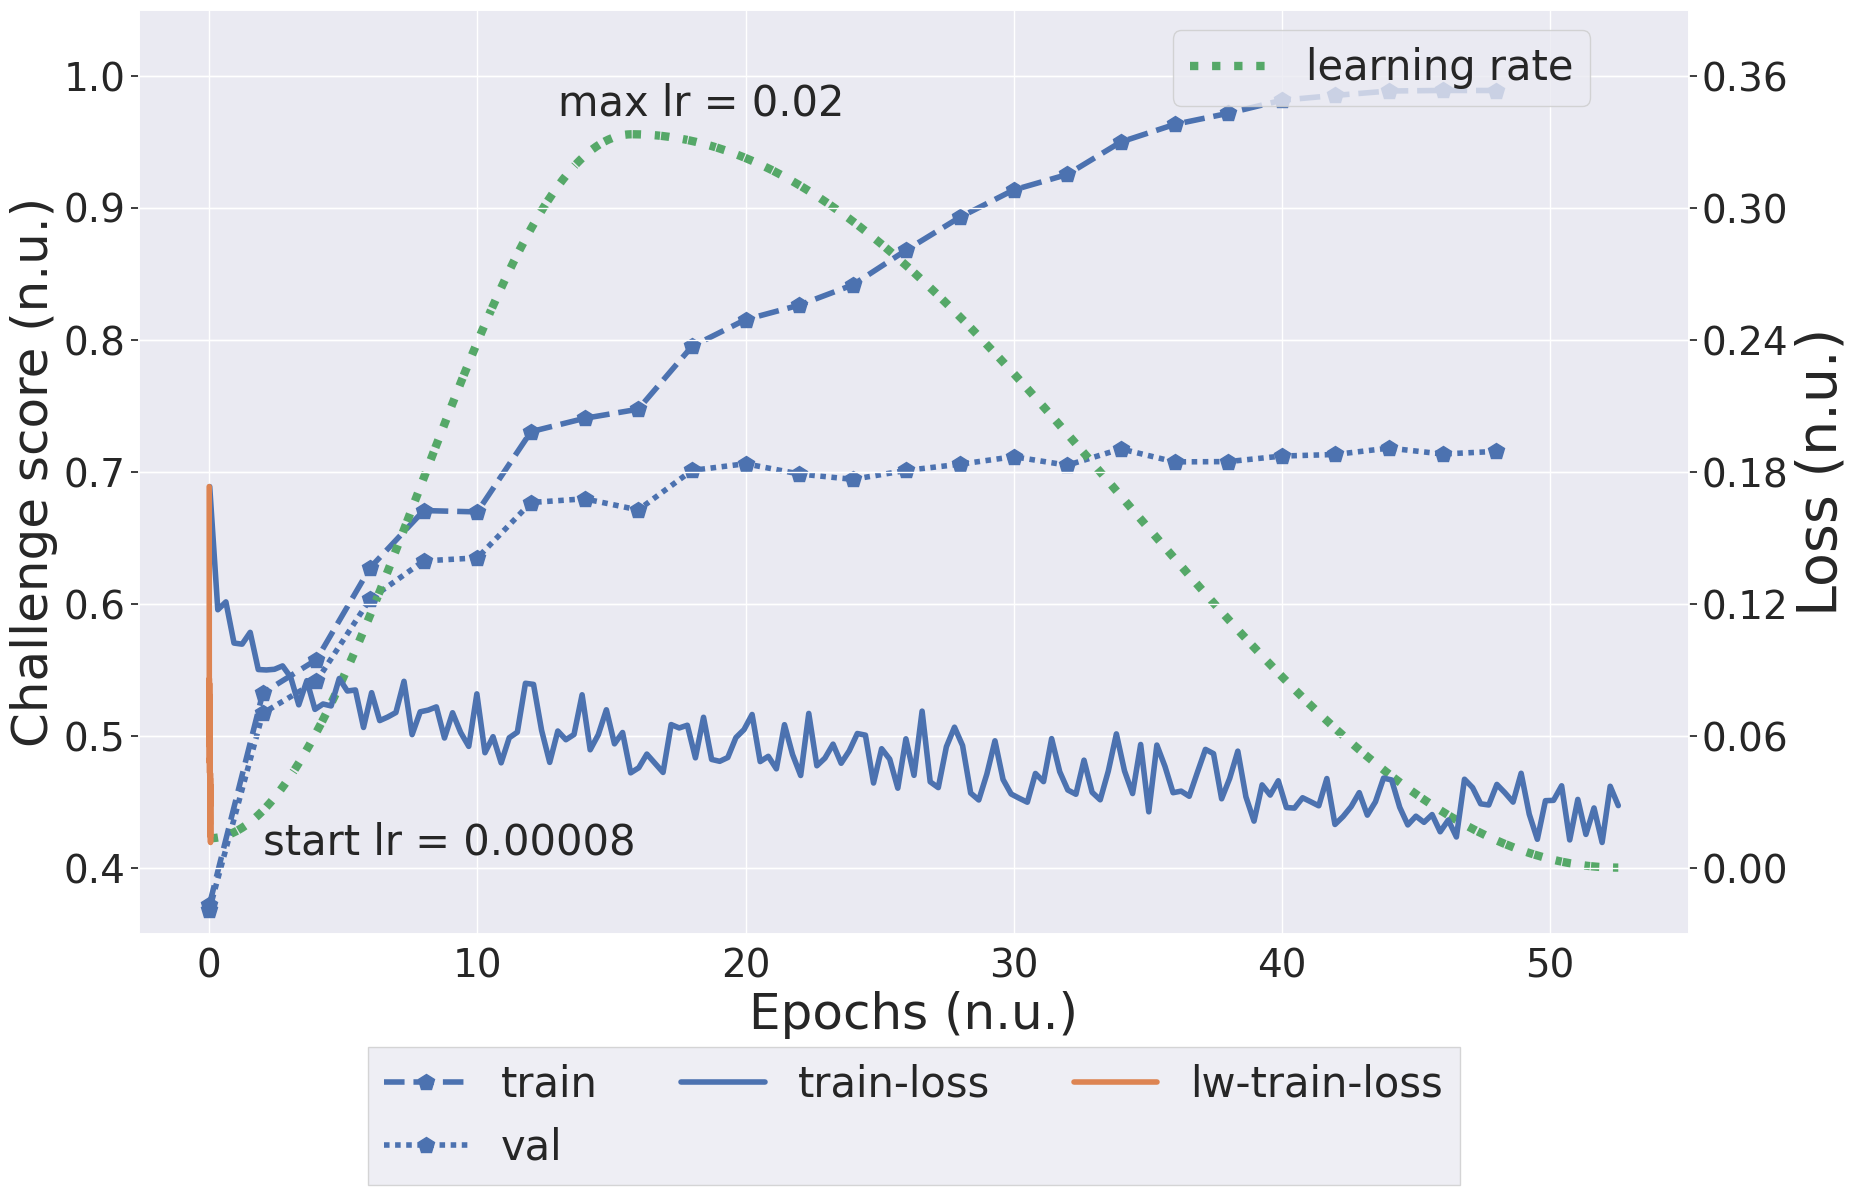

In [16]:
fig, ax = plt.subplots(figsize=(20,12))

line_width = 4

lines = []

spacing = 2
loss_spacing = 16

lines.append(ax.plot(
    df_ms_train.epoch.values[::spacing], ma(df_ms_train.challenge_metric.values)[::spacing],
    marker=markers[0], markersize=marker_size, linewidth=line_width, color=colors[0], ls="dashed", label="train",
))
# lines.append(ax.plot(
#     df_ms_lw_train.epoch.values[::spacing], ma(df_ms_lw_train.challenge_metric.values)[::spacing],
#     marker=markers[1], markersize=marker_size, linewidth=line_width, color=colors[1], ls="dashed", label="lw-train",
# ))
lines.append(ax.plot(
    df_ms_val.epoch.values[::spacing], ma(df_ms_val.challenge_metric.values)[::spacing],
    marker=markers[0], markersize=marker_size, linewidth=line_width, color=colors[0], ls=(0,(1,1)), label="val",
))
# lines.append(ax.plot(
#     df_ms_lw_val.epoch.values[::spacing], ma(df_ms_lw_val.challenge_metric.values)[::spacing],
#     marker=markers[1], markersize=marker_size, linewidth=line_width, color=colors[1], ls=(0,(1,1)), label="lw-val",
# ))
ax.set_ylim(0.35,1.05)
ax.set_xlabel("Epochs (n.u.)", fontsize=36)
ax.set_ylabel("Challenge score (n.u.)", fontsize=36)

ax2 = ax.twinx()
df_tmp = df_ms[(~df_ms.loss.isna())]
df_tmp.step = (df_tmp.step/20)/53
lines.append(ax2.plot(
    df_tmp.step.values[::loss_spacing], ma_ea(df_tmp.loss.values)[::loss_spacing],
    color=colors[0], ls="-", linewidth=line_width, label="train-loss",
))
# df_tmp = df_ms_lw[(~df_ms_lw.loss.isna())]
df_tmp.step = (df_tmp.step/20)/53
lines.append(ax2.plot(
    df_tmp.step.values[::loss_spacing], ma_ea(df_tmp.loss.values)[::loss_spacing],
    color=colors[1], ls="-", linewidth=line_width, label="lw-train-loss",
))
ax2.set_ylabel(r"Loss (n.u.)")
ax2.set_ylim(-0.03,0.39)
ax2.set_yticks(np.arange(0,0.42,0.06).tolist())

lns = list_sum(lines)
labs = [l.get_label() for l in lns]
ax.legend(
    lns, labs,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.1), ncol=3,
    fancybox=False, shadow=False, fontsize=30,
)
lr_line = ax.plot(
    df_lr.step.values[::spacing], (df_lr.lr.values/df_lr.lr.max()/1.8+0.4)[::spacing],
    linestyle=":", linewidth=6, color=colors[2],
)
ax.text(13,0.97, "max lr = 0.02", fontsize=30)
ax.text(2,0.41, f"start lr = {df_lr.lr.values[0]:.5f}", fontsize=30)
ax2.legend(lr_line, ["learning rate",], loc="upper right", fontsize=30, bbox_to_anchor=(0.95, 1));

plt.savefig("./log/cinc2021_nn_compare.svg", dpi=1200, bbox_inches="tight", transparent=False);
plt.savefig("./log/cinc2021_nn_compare.pdf", dpi=1200, bbox_inches="tight", transparent=False);